# Falcon Airlines - customer satisfaction case study

In [1480]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

## Importing datasets and joining the two tables

In [1481]:
df1 = pd.read_csv('C:/Users/Hashem Ashour/Desktop/Case Study - KPMG/Falcon Airlines/Marketing Project-Survey data.csv')
df2 = pd.read_csv('C:/Users/Hashem Ashour/Desktop/Case Study - KPMG/Falcon Airlines/Marketing Project-Flight data.csv')

In [1482]:
# Merging both tables
df = pd.merge(df1, df2, left_on=  'CustomerId', right_on=  'CustomerID', how='outer')
df_original = df.copy()

# Replacing survey data based on given dictionary
df = df.replace({"extremely poor":0, "very inconvinient":0,"poor":1, "Inconvinient":1,'need improvement':2,
                   "acceptable":3, "manageable":3, "good":4, "Convinient":4, "excellent":5, "very convinient":5})

# Placing the target variable in the last position, for ease of interpretability
last = df['Satisfaction']
df.drop(labels=['Satisfaction'], axis=1, inplace = True)
df.insert(24, 'Satisfaction', last)
df = df.drop(['CustomerID'], axis = 1)

## Getting to know our dataset

In [1483]:
pd.set_option('max_columns',30)
df.head()

,CustomerId,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins,Satisfaction
0,149965,0,0.0,0.0,2,2,4,2,3,3.0,0,3,5,3,2,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0.0,satisfied
1,149966,0,0.0,0.0,3,2,0,2,2,NaN,3,4,4,4,2,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0.0,satisfied
2,149967,0,NaN,0.0,3,3,4,3,1,1.0,0,1,4,1,3,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0.0,satisfied
3,149968,0,0.0,0.0,3,4,3,4,2,2.0,0,2,4,2,5,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0.0,satisfied
4,149969,0,0.0,0.0,3,2,0,2,2,5.0,4,5,5,4,2,Male,Loyal Customer,30,NaN,Eco,1894,0,0.0,satisfied


In [1484]:
print(df.shape, '\n')
df.info()

(90917, 24) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90917 entries, 0 to 90916
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   CustomerId                         90917 non-null  int64  
 1   Seat_comfort                       90917 non-null  int64  
 2   Departure.Arrival.time_convenient  82673 non-null  float64
 3   Food_drink                         82736 non-null  float64
 4   Gate_location                      90917 non-null  int64  
 5   Inflightwifi_service               90917 non-null  int64  
 6   Inflight_entertainment             90917 non-null  int64  
 7   Online_support                     90917 non-null  int64  
 8   Ease_of_Onlinebooking              90917 non-null  int64  
 9   Onboard_service                    83738 non-null  float64
 10  Leg_room_service                   90917 non-null  int64  
 11  Baggage_handling                   90917

### Checking Target variable distribution

In [1485]:
df['Satisfaction'].value_counts(normalize=True)

satisfied                  0.547323
neutral or dissatisfied    0.452677
Name: Satisfaction, dtype: float64

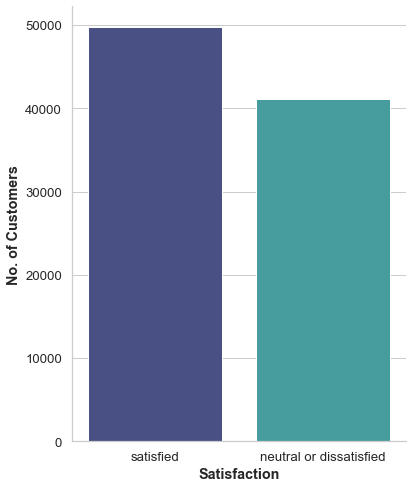

In [1486]:
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df,x='Satisfaction',palette='mako')
plt.xlabel('Satisfaction',weight='bold')   
plt.ylabel('No. of Customers',weight='bold')  
sns.despine()

#### We see that the target variable 'Satisfaction' is quite evenly distributed

## Checking correlation between all columns

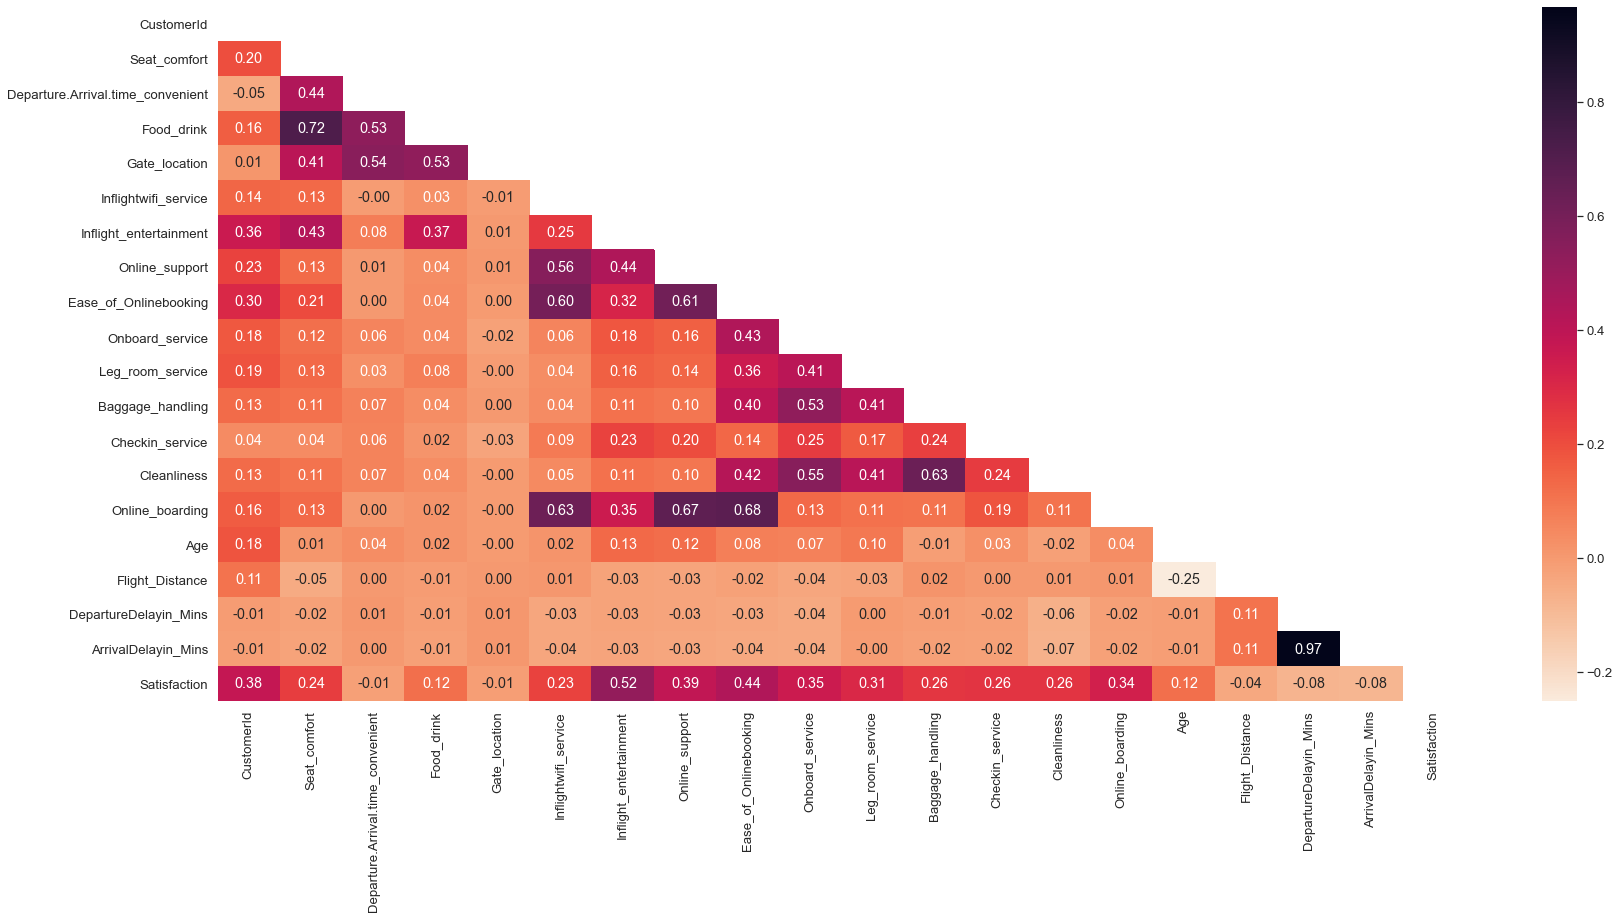

In [1487]:
# Changing values in the satisfied column to plot correlation
df = df.replace({"satisfied":1, "neutral or dissatisfied":0})

corrmat = df.corr()
fig = plt.figure(figsize=(25,13))
mask = np.triu(np.ones_like(corrmat, dtype=bool))
sns.heatmap(df.dropna().corr(),annot=True, mask = mask, fmt='0.2f', cmap = 'rocket_r')
plt.tight_layout()

## Data cleaning

#### Checking which columns have null values and percentage of missing values in each column

In [1488]:
print('Percent of missing values by column: ')
df.isnull().sum() * 100 / len(df)

Percent of missing values by column: 


CustomerId                            0.000000
Seat_comfort                          0.000000
Departure.Arrival.time_convenient     9.067611
Food_drink                            8.998317
Gate_location                         0.000000
Inflightwifi_service                  0.000000
Inflight_entertainment                0.000000
Online_support                        0.000000
Ease_of_Onlinebooking                 0.000000
Onboard_service                       7.896213
Leg_room_service                      0.000000
Baggage_handling                      0.000000
Checkin_service                       0.000000
Cleanliness                           0.000000
Online_boarding                       0.000000
Gender                                0.000000
CustomerType                         10.008029
Age                                   0.000000
TypeTravel                            9.995930
Class                                 0.000000
Flight_Distance                       0.000000
DepartureDela

### We will move along each column containing null values and decide what the best approach is to deal with them

#### Departure.Arrival.time_convenient

This column has nearly 0 (-0.02) correlation with our target variable  and has the highest percentage of null values (9%). The best solution for this column would be to  remove it entirely from our dataset

In [1489]:
df = df.drop(['Departure.Arrival.time_convenient'], axis = 1)

#### Food_drink

This column also contains many null values, but is more important to keep in our dataset due to it's higher 
correlation with our target variable. As we can see from the plot below, the data is quite evenly distributed. With the values being all close to one another, it would not make sense to attribute all null values (8.99%) to the most occuring value in this column. 

Logically, the best approach would be to remove all the rows with nulls in the Food_drink column. But if we did not want to
lose this portion of data, we could use a classification model to predict where our null values should be placed and use that to fill our null values

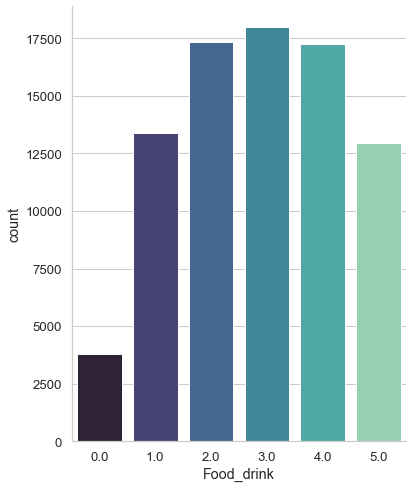

In [1490]:
#plotting distribution of Food_drink
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df,x='Food_drink',palette='mako')
sns.despine()

In [1491]:
# recreating dataset where the 'Food_drink' column is not null
df = df[df['Food_drink'].notna()]

#### Onboard_service

This column is quite biased towards the score '4', immediately we know we can replace the null values with our mode value to get a relatively accurate representation of our dataset. Before moving forward with that solution, we tried to find a correlation between our missing values in the 'Onboard_service' column with other columns, especially those that are highly correlated with it (such as: cleanliness, baggage_handling, and checkin_service). 

What we were looking for was a different distribution of the other columns when the 'Onboard_service' column was null, this would have indicated that there was an underlying trend for these null value, but there was no such trend to be found.

Given that, we return to our initial best solution and replace our null values in the 'Onboard_service' with the mode of that column

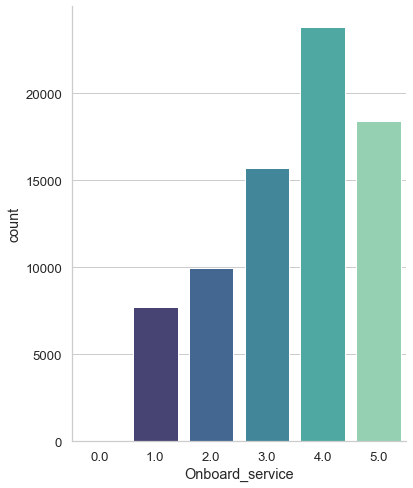

In [1492]:
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df,x='Onboard_service',palette='mako')
sns.despine()

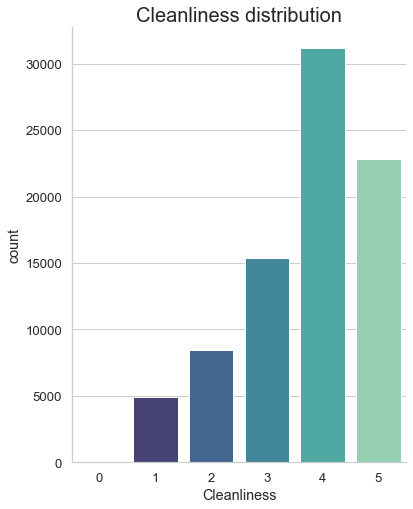

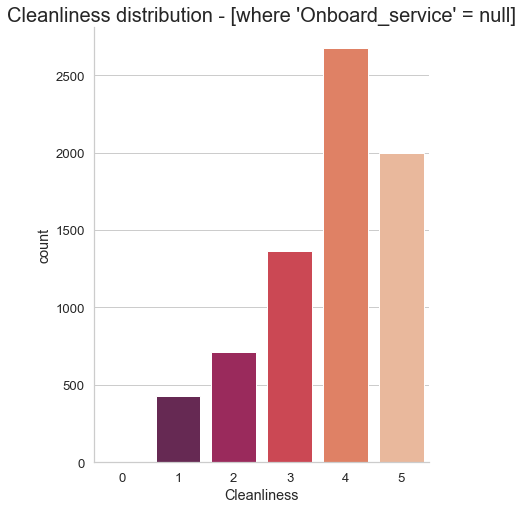

In [1493]:
#creating a dataset using only rows that are null under the 'Onboard_service' column
on_board_null = df[df['Onboard_service'].isna()]

# Regular Cleanliness distribution
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df,x='Cleanliness',palette='mako')
ax.set_title("Cleanliness distribution", fontsize = 20)
sns.despine()

# Cleanliness distribution, where 'Onboard_service' column is null 
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=on_board_null,x='Cleanliness',palette='rocket')
ax.set_title("Cleanliness distribution - [where 'Onboard_service' = null]", fontsize = 20)
sns.despine()

In [1494]:
# The best solution here in my opinion is to use the most common value in the column to replace our null values.
df['Onboard_service'].fillna(df['Onboard_service'].mode()[0], inplace=True)

Given some time, one possible approach for the null values in our 'Onboard_service' column could be to use a classification model to predict the null values based on the other columns in the dataset. This could be very useful when the column is correlated highly with our target.

#### CustomerType

Based on the data exploration shown below, the best approach to dealing with null values in the CustomerType column was to assign all null values where (TypeTravel is business travel and Class is Eco and Satisfaction = 0) as disloyal Customers, and all other null values as Loyal customers

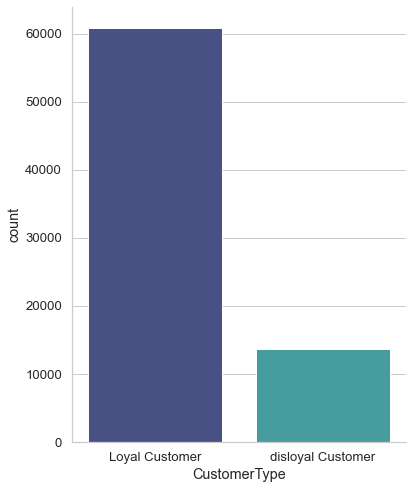

In [1495]:
#plotting distribution of CustomerType
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df,x='CustomerType',palette='mako')
sns.despine()

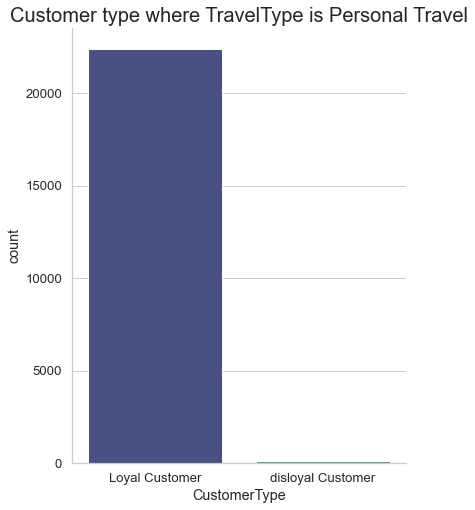

In [1496]:
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df_original[df_original['TypeTravel'] == 'Personal Travel'],
                   x='CustomerType',palette='mako')  
ax.set_title("Customer type where TravelType is Personal Travel", fontsize = 20)
sns.despine()

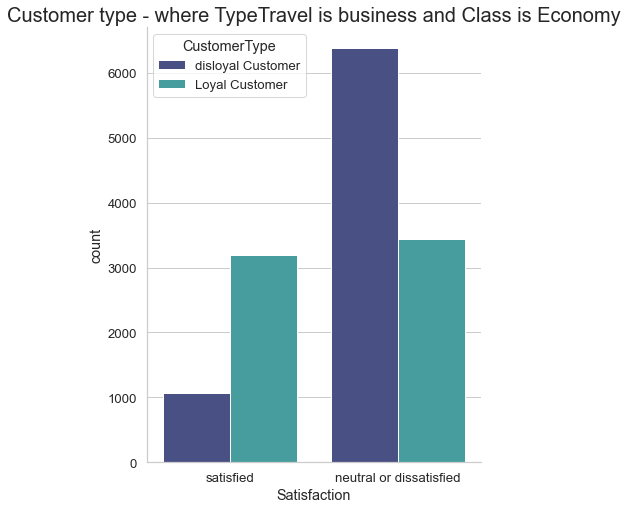

In [1497]:
business = df_original[df_original['TypeTravel'] == 'Business travel']

sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=business[business['Class'] == 'Eco'],
                   x='Satisfaction', hue='CustomerType' ,palette='mako') 
ax.set_title("Customer type - where TypeTravel is business and Class is Economy", fontsize = 20)

sns.despine()

In [1498]:
# in a new dataframe, filling nulls only for those who satisfy the below criteria
df_customer = df['CustomerType'][(df['TypeTravel'] == 'Business travel') & (df['Class'] == 'Eco') & (df['Satisfaction'] == 0)].fillna(value= 'disloyal Customer')
df.update(df_customer)

# filling in the rest of the nulls in the CustomerType column
df['CustomerType'].fillna(value='Loyal Customer', inplace=True)

#### TypeTravel

Here, based on the below charts, we assign all null values where Class is Eco and CustomerType is Loyal to the Personal travel and all other null values assigned to business travel. 

There needs to be careful consideration with this approach as we are building on our previous assumptions where we assigned null values of the CustomerType column based on values in our TypeTravel column.

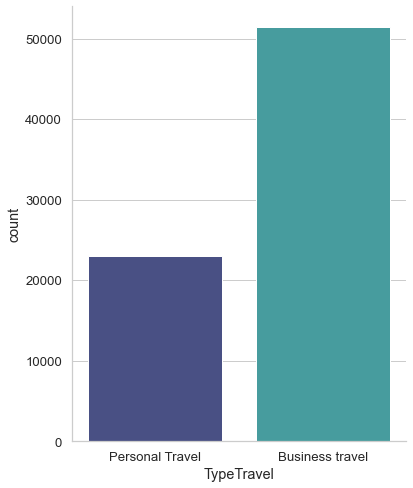

In [1499]:
#plotting distribution of TypeTravel
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df,x='TypeTravel',palette='mako')
sns.despine()

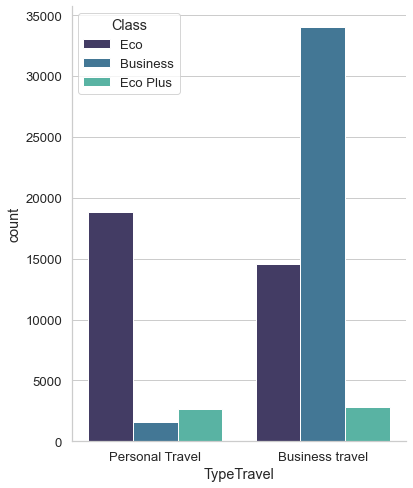

In [1500]:
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df,
                   x='TypeTravel', hue='Class' ,palette='mako')  
sns.despine()

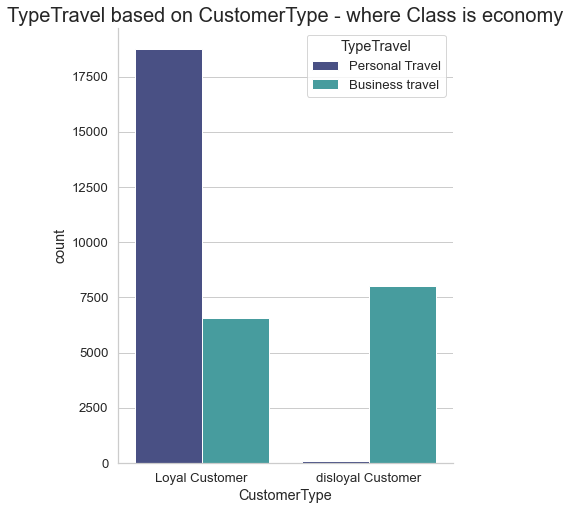

In [1501]:
#business = df_original[df_original['TypeTravel'] == 'Business travel']

sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df[df['Class'] == 'Eco'],
                   x='CustomerType', hue='TypeTravel' ,palette='mako')  
ax.set_title("TypeTravel based on CustomerType - where Class is economy", fontsize = 20)
sns.despine()

In [1502]:
# in a new dataframe, filling nulls only for those who satisfy the below criteria
df_type = df['TypeTravel'][(df['CustomerType'] == 'Loyal Customer') & (df['Class'] == 'Eco')].fillna(value= 'Personal Travel')
df.update(df_type)

# filling in the rest of the nulls in the CustomerType column
df['TypeTravel'].fillna(value='Business travel', inplace=True)

#### ArrivalDelayin_Mins

Regarding 'ArrivalDelayin_Mins', we notice that this column is extremely correlated with the column 'DepartureDelayin_Mins' this brings up an issue of multicollinearity that might affect some of the models which we will be testing with further on. 

The best solution here would be to drop this column as both arrival delay and departure delay columns serve the same purpuse to an extent

In [1503]:
df = df.drop(['ArrivalDelayin_Mins'], axis = 1)

In [1504]:
#copying dataset for future use
df_copy = df.copy()

### Replacing flight data variables with dummies

In [1505]:
# Replacing flight data with dummies
df = pd.get_dummies(df,columns=['Gender','CustomerType','TypeTravel','Class'],drop_first=True)

# Placing Target variable as last column
last = df['Satisfaction']
df.drop(labels=['Satisfaction'], axis=1, inplace = True)
df.insert(22, 'Satisfaction', last)

### Running correlation plot with all variables showing

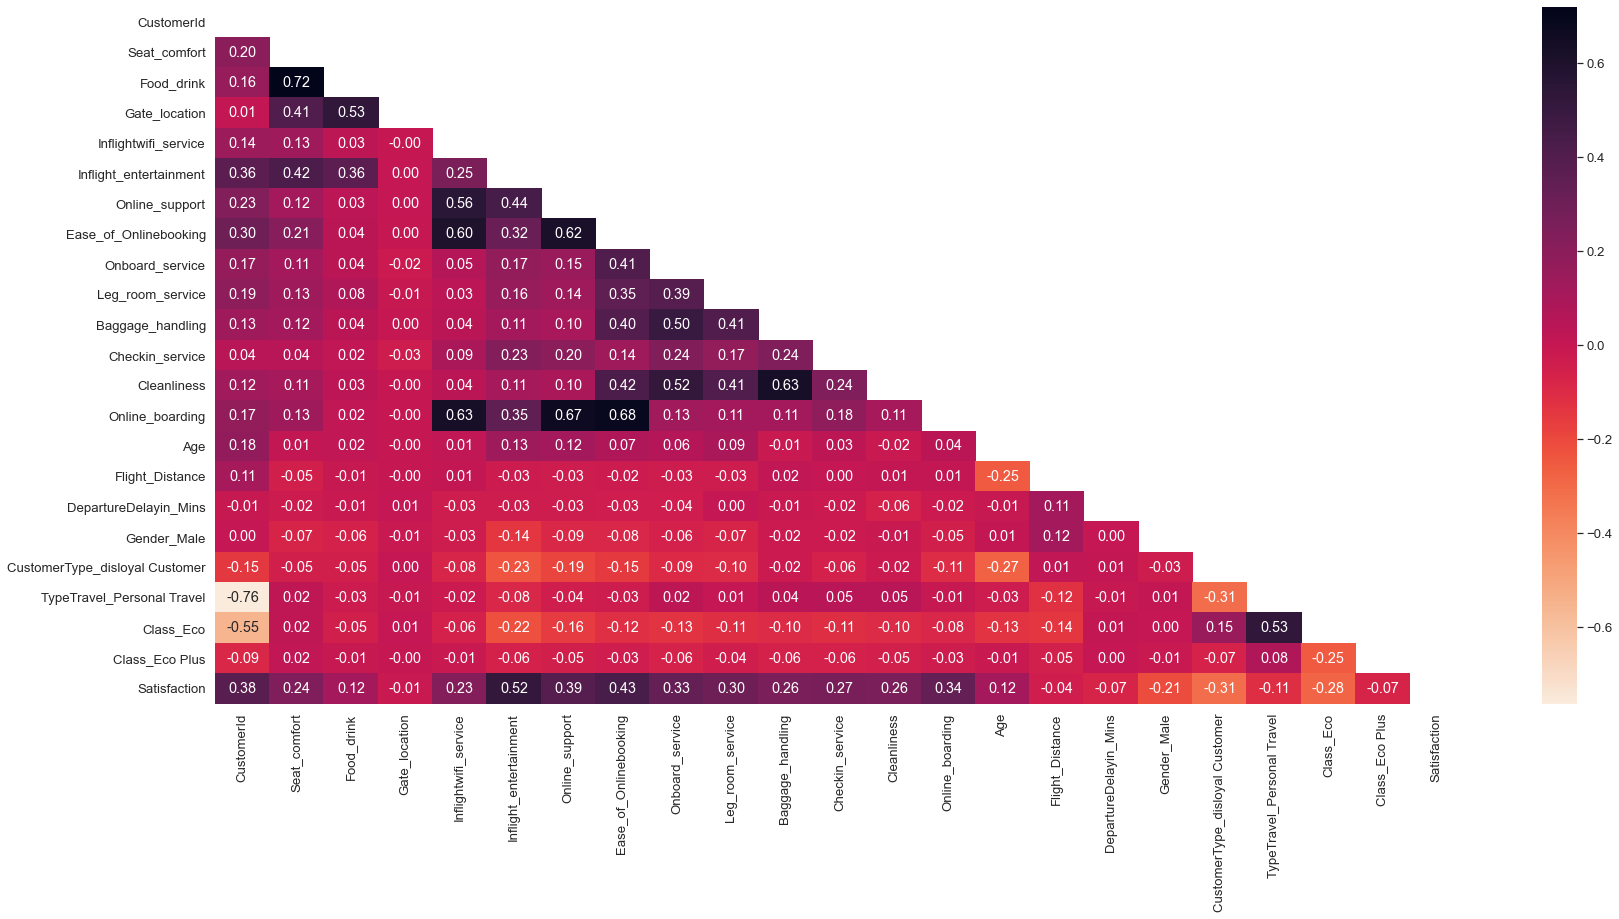

In [1506]:
# running correlation again after adding dummy variables
corrmat = df.corr()
fig = plt.figure(figsize=(25,13))
mask = np.triu(np.ones_like(corrmat, dtype=bool))
sns.heatmap(df.dropna().corr(),annot=True, mask = mask, fmt='0.2f', cmap = 'rocket_r')
plt.tight_layout()

## Exploring our data further

Before making any assumptions, we will explore our data visually and try to see if there are any obvious patterns and interesting relationships in our data.

#### As our target metric is 'Satisfaction', we will be focusing on that mainly with our Exploratory data analysis

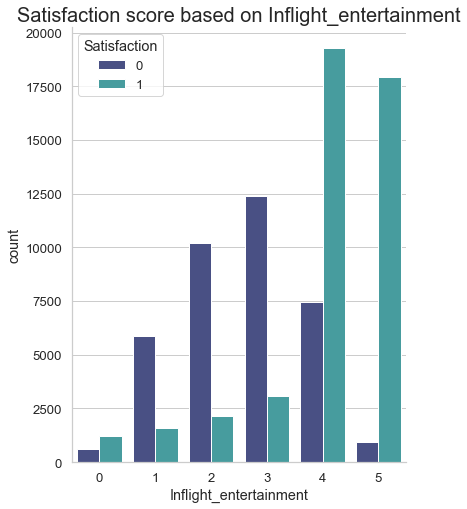

In [1507]:
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df,x='Inflight_entertainment',hue='Satisfaction',palette='mako')  
ax.set_title("Satisfaction score based on Inflight_entertainment", fontsize = 20)
sns.despine()

We see here that when a customer gives inflight_entertainment a higher score (4-5), they are very likely to give an overal satisfaction score of 'Satisfied'.

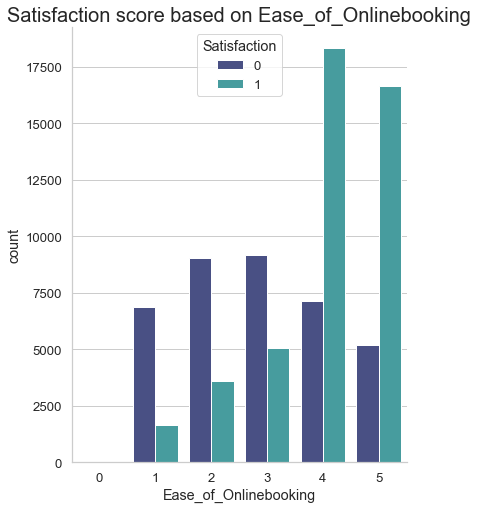

In [1508]:
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df,x='Ease_of_Onlinebooking',hue='Satisfaction',palette='mako')  
ax.set_title("Satisfaction score based on Ease_of_Onlinebooking", fontsize = 20)
sns.despine()

Ease_of_Onlinebooking also scores highly when users are satisfied, both columns score highly in the correlation matrix above

### Understanding our satisfaction score based on our customers

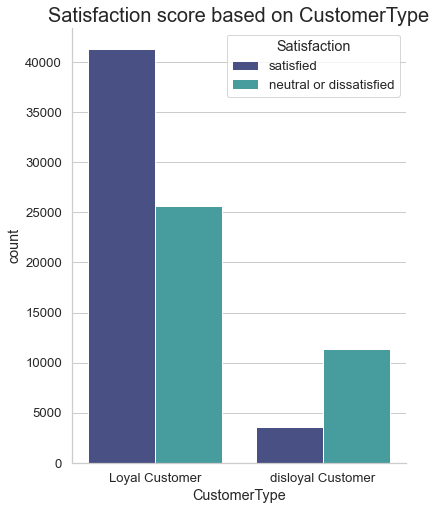

In [1509]:
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df_original,x='CustomerType',hue='Satisfaction',palette='mako')  
ax.set_title("Satisfaction score based on CustomerType", fontsize = 20)
sns.despine()

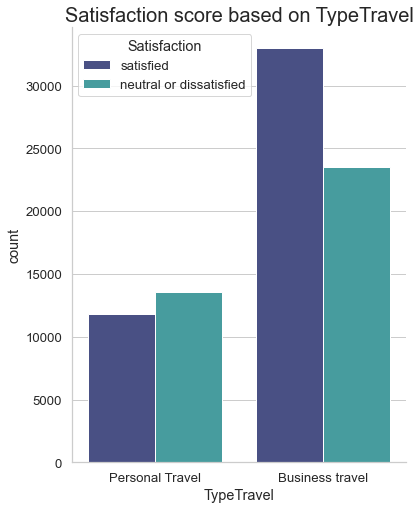

In [1510]:
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df_original,x='TypeTravel',hue='Satisfaction',palette='mako')  
ax.set_title("Satisfaction score based on TypeTravel", fontsize = 20)
sns.despine()

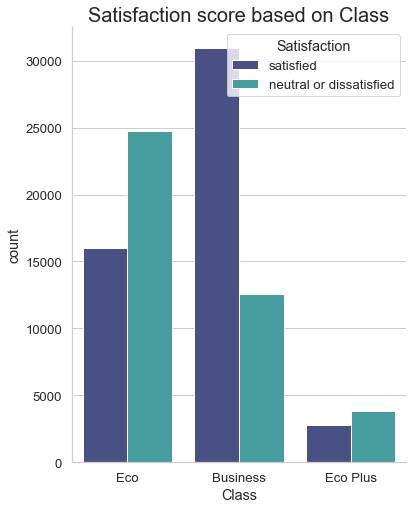

In [1511]:
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df_original,x='Class',hue='Satisfaction',palette='mako')  
ax.set_title("Satisfaction score based on Class", fontsize = 20)
sns.despine()

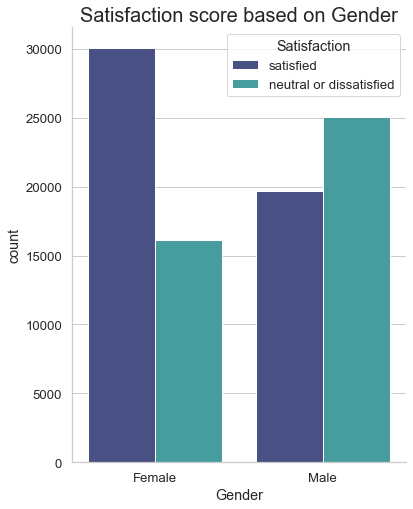

In [1512]:
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df_original,x='Gender',hue='Satisfaction',palette='mako')  
ax.set_title("Satisfaction score based on Gender", fontsize = 20)
sns.despine()

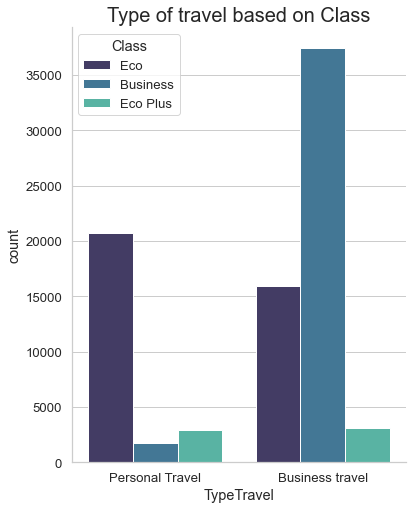

In [1513]:
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df_original,x='TypeTravel',hue='Class',palette='mako')  
ax.set_title("Type of travel based on Class", fontsize = 20)
sns.despine()

Business travel    56481
Personal Travel    25348
Name: TypeTravel, dtype: int64

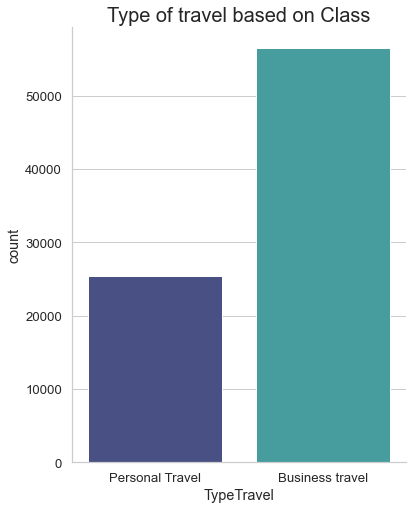

In [1514]:
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=[6,8])
ax = sns.countplot(data=df_original,x='TypeTravel',palette='mako')  
ax.set_title("Type of travel based on Class", fontsize = 20)
sns.despine()

df_original['TypeTravel'].value_counts()

## Feature selection

In [1515]:
corrmat = df.corr()
cor_target = abs(corrmat["Satisfaction"])

#selecting only 'highly' correlated features
relevant_features = cor_target[cor_target > 0.1]
print(relevant_features)

CustomerId                        0.378070
Seat_comfort                      0.240115
Food_drink                        0.117964
Inflightwifi_service              0.226554
Inflight_entertainment            0.520818
Online_support                    0.388422
Ease_of_Onlinebooking             0.431265
Onboard_service                   0.333719
Leg_room_service                  0.304114
Baggage_handling                  0.258473
Checkin_service                   0.267161
Cleanliness                       0.259251
Online_boarding                   0.335364
Age                               0.116446
Gender_Male                       0.212195
CustomerType_disloyal Customer    0.306843
TypeTravel_Personal Travel        0.109602
Class_Eco                         0.279790
Satisfaction                      1.000000
Name: Satisfaction, dtype: float64


In [1516]:
X = df[['Seat_comfort', 'Food_drink', 'Inflightwifi_service', 'Inflight_entertainment', 'Online_support',
       'Ease_of_Onlinebooking', 'Onboard_service', 'Leg_room_service', 'Baggage_handling', 'Checkin_service',
      'Cleanliness', 'Online_boarding', 'Age', 'Gender_Male', 'CustomerType_disloyal Customer', 
       'TypeTravel_Personal Travel', 'Class_Eco']]
y = df['Satisfaction']

Feature scaling will not be necessary for the models we will be using to predict customer satisfaction

## Train-Test Split

In [1517]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

## Data modeling

Here all our models will have the scoring parameters set to 'precision', this is based on the assumption I have made from the objective of the project which stated to find the best parameters to sway the passenger feedback towards satisfied. Meaning that when predictiing '1' or 'Satisfied', we should be as accurate as possible.

In the param_grid, I am identifying the parameters I want to test with and the range values for each parameter I will test with.

After cross-validation, I will print out several evaluation scores which I believe are always important to keep in mind of. Although our decision making will be done based on the 'precision' evaluation metric to ensure our predictions of 'Satisfied' are as accurate as possible

Instead of manually testing all 5 classifiers, a better approach could be to run a gridsearchCV across all classifiers.

### Logistic regression classifier

In [1518]:
param_grid = {
'penalty' : ['l1', 'l2'],
'C' : np.logspace(-4, 4, 20),
'solver' : ['liblinear']
}

In [1519]:
clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='precision')
best_clf = clf.fit(X_train, y_train)

best_clf.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   43.5s finished


LogisticRegression(C=29.763514416313132, penalty='l1', solver='liblinear')

In [1520]:
logistic_model = LogisticRegression(C=29.763514416313132, penalty='l1', solver='liblinear')
logistic_model.fit(X_train, y_train)

score=cross_val_score(logistic_model,X,y,cv=10)
score.mean()

0.7819347974914889

In [1521]:
y_pred = logistic_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
logistic_precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
prc = average_precision_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (logistic_precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))
print("AUROC: %.2f%%" % (auc * 100.0))
print("AUPRC: %.2f%%" % (prc * 100.0))

Accuracy: 83.42%
Precision: 84.62%
Recall: 85.17%
F1: 84.90%
AUROC: 83.24%
AUPRC: 80.18%


### Random forest classifier

In [1077]:
param_grid = {
'n_estimators' : list(range(2,46,4)),
'max_features' : list(range(2,46,6)),
'max_depth':[21,23,25,27,28,29]
}

In [1078]:
clf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='precision')
best_clf = clf.fit(X_train, y_train)

best_clf.best_estimator_

Fitting 5 folds for each of 528 candidates, totalling 2640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1250 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2450 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 2640 out of 2640 | elapsed:  8.2min finished


RandomForestClassifier(max_depth=28, max_features=8, n_estimators=2)

In [1079]:
r_foreset_model = RandomForestClassifier(max_depth=28, max_features=8, n_estimators=2)
r_foreset_model.fit(X_train, y_train)

score=cross_val_score(r_foreset_model,X,y,cv=10)
score.mean()

0.8233562581195178

In [1093]:
y_pred = r_foreset_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
random_forest_precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
prc = average_precision_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (random_forest_precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))
print("AUROC: %.2f%%" % (auc * 100.0))
print("AUPRC: %.2f%%" % (prc * 100.0))

Accuracy: 92.00%
Precision: 96.90%
Recall: 88.19%
F1: 92.34%
AUROC: 92.39%
AUPRC: 91.92%


### Decision tree classifier 

In [714]:
param_grid = {
'max_depth' : list(range(5,20)),
'max_features' : list(range(6,32,5)),
'criterion' : ['gini', 'entropy']
}

In [712]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [719]:
clf = GridSearchCV(DecisionTreeClassifier(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='precision')
best_clf = clf.fit(X_train, y_train)

best_clf.best_estimator_

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1785 out of 1800 | elapsed:   43.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   43.4s finished


DecisionTreeClassifier(criterion='entropy', max_depth=13, max_features=16)

In [717]:
d_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=13, max_features=16)
d_tree_model.fit(X_train, y_train)

score=cross_val_score(d_tree_model,X,y,cv=10)
score.mean()

0.8454619523668985

In [1094]:
y_pred = d_tree_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
d_tree_precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
prc = average_precision_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (d_tree_precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))
print("AUROC: %.2f%%" % (auc * 100.0))
print("AUPRC: %.2f%%" % (prc * 100.0))

Accuracy: 92.63%
Precision: 95.48%
Recall: 90.83%
F1: 93.10%
AUROC: 92.82%
AUPRC: 91.74%


### Gradient boosting classifier

In [724]:
param_grid = {
    "n_estimators":[250,500],
    "max_depth":[5,7,9],
    "learning_rate":[0.01,0.1,1,10]
}

param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

In [725]:
clf = GridSearchCV(GradientBoostingClassifier(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='precision')
best_clf = clf.fit(X_train, y_train)

best_clf.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  9.1min finished


GradientBoostingClassifier(max_depth=7, n_estimators=250)

In [726]:
gb_model = GradientBoostingClassifier(max_depth=7, n_estimators=250)
gb_model.fit(X_train, y_train)

score=cross_val_score(gb_model,X,y,cv=10)
score.mean()

0.8637602113120602

In [1095]:
y_pred = gb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
gb_precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
prc = average_precision_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (gb_precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))
print("AUROC: %.2f%%" % (auc * 100.0))
print("AUPRC: %.2f%%" % (prc * 100.0))

Accuracy: 94.99%
Precision: 96.30%
Recall: 94.48%
F1: 95.38%
AUROC: 95.04%
AUPRC: 94.00%


### XGBoost classifier

In [752]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7, 0.8, 0.9 ],
 "scale_pos_weight" : [1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12, 13, 14]
}

param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [2, 5],
        'subsample': [0.4, 0.6],
        'colsample_bytree': [0.8, 1.0, 1.2],
        'max_depth': [5, 7]
        }

In [753]:
clf = GridSearchCV(xgb.XGBClassifier(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='precision')
best_clf = clf.fit(X_train, y_train)

best_clf.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.2min finished


XGBClassifier(colsample_bytree=1.0, gamma=2, max_depth=7, subsample=0.6)

In [754]:
XGB_model = xgb.XGBClassifier(colsample_bytree=1.0, gamma=2, max_depth=7, subsample=0.6)
XGB_model.fit(X_train, y_train)

score=cross_val_score(XGB_model,X,y,cv=10)
score.mean()

0.8647153177255686

In [1096]:
y_pred = XGB_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
XGB_precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
prc = average_precision_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (XGB_precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))
print("AUROC: %.2f%%" % (auc * 100.0))
print("AUPRC: %.2f%%" % (prc * 100.0))

Accuracy: 94.39%
Precision: 95.50%
Recall: 94.18%
F1: 94.83%
AUROC: 94.41%
AUPRC: 93.12%


                 model  precision_score
1        random_forest         0.969042
3    gradient_boosting         0.962950
4              xgboost         0.954963
2        decision_tree         0.954820
0  logistic_regression         0.843284


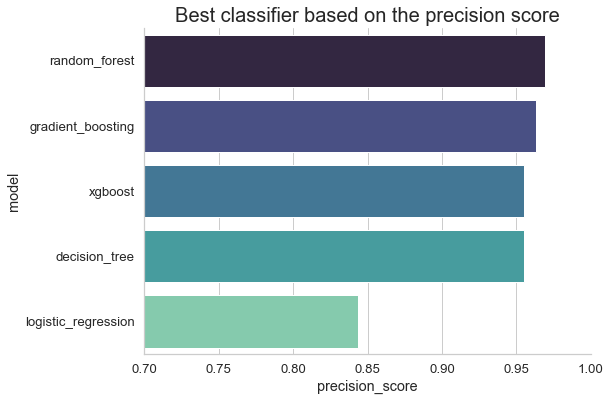

In [1119]:
scores = pd.DataFrame({'model':'logistic_regression','precision_score': logistic_precision}, index = [0])
scores = scores.append({'model':'random_forest','precision_score': random_forest_precision}, ignore_index = True)
scores = scores.append({'model':'decision_tree','precision_score': d_tree_precision}, ignore_index = True)
scores = scores.append({'model':'gradient_boosting','precision_score': gb_precision}, ignore_index = True)
scores = scores.append({'model':'xgboost','precision_score': XGB_precision}, ignore_index = True)
scores = scores.sort_values(by='precision_score', ascending = False)

print(scores)

fig = plt.figure(figsize=[8,6])
ax = sns.barplot(x="precision_score", y="model", data=scores, palette="mako", orient = 'h')
ax.set_title("Best classifier based on the precision score", fontsize = 20)
ax.set(xlim=(0.7,1))
sns.despine()

Clearly, there is not much of a difference in our classifier scores between random forest and gradient boosting. Although it would be best to avoid XGBoost for such a small dataset, as it tends to overfit

## Best classifier - Random forest

After testing, the Random forest classifier (max_depth=28, max_features=8, n_estimators=2) is the best model when looking at the 'Precision' metric.
This decision is made with the assumption that 'Precision' is our most important classifier to improve. 

Our next steps are to:
- find the most important parameters to sway passenger feedback towards 'satisfied'
- predict customer satisfaction with new data

## Finding most important parameters in swaying passenger feedback towards 'satisfied'

                           feature  importance
3           Inflight_entertainment    0.187074
5            Ease_of_Onlinebooking    0.142119
0                     Seat_comfort    0.139045
11                 Online_boarding    0.068427
4                   Online_support    0.066886
7                 Leg_room_service    0.054481
14  CustomerType_disloyal Customer    0.052266
12                             Age    0.051010
1                       Food_drink    0.037887
6                  Onboard_service    0.036885
13                     Gender_Male    0.034663
9                  Checkin_service    0.027241
8                 Baggage_handling    0.023922
15      TypeTravel_Personal Travel    0.023896
10                     Cleanliness    0.021891
2             Inflightwifi_service    0.016947
16                       Class_Eco    0.015360 



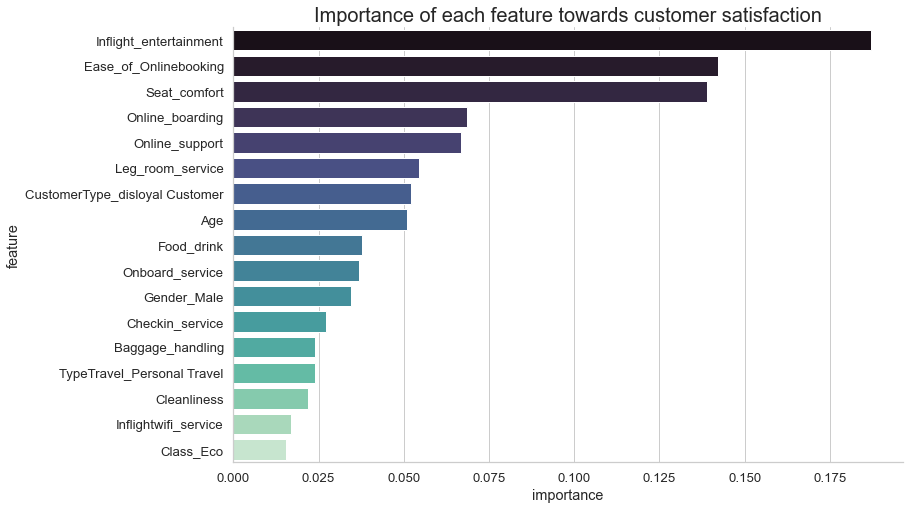

In [1083]:
r_foreset_model.feature_importances_
importance = pd.DataFrame({'feature':X_train.columns,'importance': r_foreset_model.feature_importances_})
importance = importance.sort_values(by='importance', ascending = False)
print(importance, '\n')

fig = plt.figure(figsize=[12,8])
ax = sns.barplot(x="importance", y="feature", data=importance, palette="mako", orient = 'h')
ax.set_title("Importance of each feature towards customer satisfaction", fontsize = 20)
sns.despine()

## Making predictions on new data

Assuming new data coming in for prediction will look like our original datasets, we will have to apply first the necessary data engineering changes we have already applied to our data in order to make the predictions. These steps are: 
  - Joining both datasets
  - Replacing feature variables to numerical data
  - Cleaning null data
  - Removing CustomerID and returning it after making prediction
  - Feature selection
  - Feature scaling
  
Given that we do not have that data available, we will move forward with our X_test dataset which this process has already been applied to

In [1082]:
df_inference = X_test.copy()

# making prediction
prediction = r_foreset_model.predict(df_inference)

# adding prediction to dataset
df_inference['prediction'] = prediction

# adding back customerID to dataset
df_inference = df_inference.join(pd.DataFrame(df_copy['CustomerId']))

df_inference

,Seat_comfort,Food_drink,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Age,Gender_Male,CustomerType_disloyal Customer,TypeTravel_Personal Travel,Class_Eco,prediction,CustomerId
61431,3,3.0,5,5,4,3,3.0,4,3,4,3,5,38,0,0,0,0,1,211396
58783,3,2.0,3,3,3,1,3.0,4,3,3,4,3,25,0,0,0,0,0,208748
89574,5,2.0,5,5,5,5,1.0,3,5,1,1,5,63,1,0,0,1,1,239539
2027,1,1.0,5,1,2,5,3.0,5,3,4,3,5,42,1,0,1,1,0,151992
78296,1,1.0,4,5,4,4,4.0,4,3,4,4,4,25,0,0,0,0,1,228261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34550,2,2.0,2,2,2,2,4.0,3,3,2,2,2,21,0,1,0,0,0,184515
40026,4,4.0,1,4,1,1,4.0,2,5,3,5,1,24,1,1,0,0,1,189991
56938,3,2.0,3,3,4,3,3.0,3,3,4,3,1,48,1,0,0,0,0,206903
87764,1,1.0,5,5,5,5,4.0,5,5,5,5,5,52,1,0,0,0,1,237729
